In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('ticks')
# get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

In [2]:
dataDirectory = '/home/h1bennet/strains/data/H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Make Nice PCA for pub

In [3]:
if not os.path.isdir('./fancy_figures'):
    os.mkdir('./fancy_figures')

### Read in annotation files

In [4]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low tag peaks prior to making summary plots

In [5]:
# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
groups=[[0,1], [2,3], [4,5]]
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > 5, :].index.tolist())
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(list(set(peaks)))
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

63491 total peaks
filtering low tag count peaks
58762 total peaks


# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [6]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns.str.split('/').str[-1])
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[1]
cell = samples.str.split('_').str[2]
treatment = samples.str.split('_').str[4]
treatment_time = samples.str.split('_').str[5]
mouseid = samples.str.split('_').str[6]
sampledate = samples.str.split('_').str[7]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(cell),
                          pd.Series(treatment),
                          pd.Series(treatment_time),
                          pd.Series(mouseid),
                          pd.Series(sampledate)],
                         index=['mouse', 'group', 'strain', 'celltype',
                                'treatment', 'treatment_time', 'mouse_id',
                                'sample_date']).T

### Look at PCA plots for all the samples

In [13]:
colors = ['#4daf4a', '#377eb8', '#e41a1c']
sns.set_palette(sns.color_palette(colors))

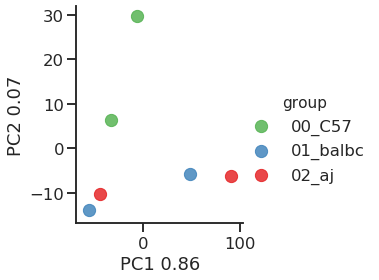

In [14]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.group+'_'+samplesDF.strain,
                                 plot_size=4,
                                 n_pca=3)

# label_point(pca.PC1,
#             pca.PC2,
#             samplesDF.mouse_id,
#             plt.gca())

plt.savefig('./fancy_figures/h3k27ac_pca1_pca2.pdf', bbox_inches='tight')

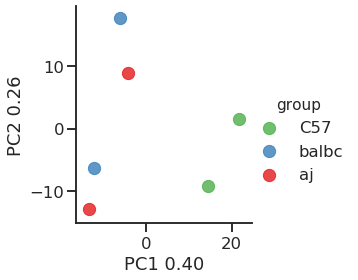

In [15]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.strain,
                                 plot_size=4,
                                 n_pca=3)
# label_point(pca.PC1,
#             pca.PC2,
#             samplesDF.mouse_id,
#             plt.gca())

plt.savefig('./fancy_figures/h3k27ac_pca1_pca2_quantnorm.pdf', bbox_inches='tight')

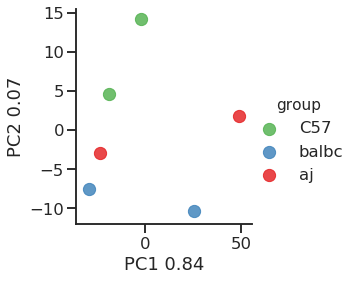

In [16]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.strain,
                                 plot_size=4,
                                 n_pca=3)

# label_point(pca.PC1,
#             pca.PC2,
#             samplesDF.mouse_id,
#             plt.gca())

plt.savefig('./fancy_figures/h3k27ac_distal_pca1_pca2.pdf', bbox_inches='tight')

We only have two replicates for all strains so no filtering today!

# Make venn diagram of 'active' enhancers

In [76]:
from matplotlib_venn import venn3

In [77]:
groups = ['C57Bl6J', 'BALBcJ', 'AJ']
columns = [[0,1],
           [2,3],
           [4,5]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

In [78]:
thresh=16

peak_dict = {}
for col in avg_tags_df.columns:
    peak_dict[col] = avg_tags_df.index[avg_tags_df[col]>thresh].tolist()

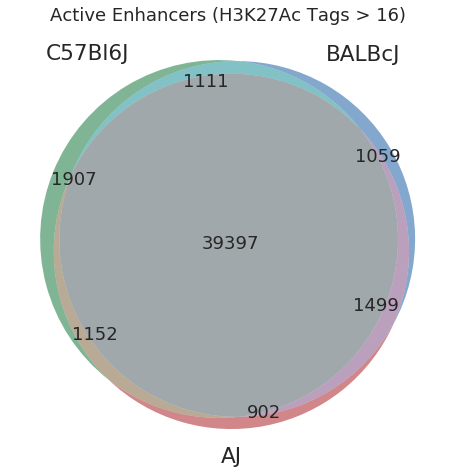

In [79]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(peak_dict['C57Bl6J']),
               set(peak_dict['BALBcJ']),
               set(peak_dict['AJ'])],
      set_colors=('#006d2c', '#08519c', '#a50f15'),
      set_labels=('C57Bl6J', 'BALBcJ', 'AJ'),
      alpha=0.5,
      ax=ax)
ax.set_title('Active Enhancers (H3K27Ac Tags > 16)');

plt.savefig('./figures/venn3_activated_peaks.png', bbox_inches='tight')